<a href="https://colab.research.google.com/github/kkattt51/ArtInt/blob/main/6_%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_%D0%9C%D0%B5%D0%B3%D0%B0%D0%A4%D0%BE%D0%BD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Моя первая модель ML

В данном ноутбуке проводится демонстрация построения простой модели линейной регрессии с освещением основных этапов, из которых (обычно) состоит работа по обучению моделей. В данном ноутбуке не демоснтрируются абсолютно все возможные техники работы с данными, в т.ч. разведочный анализ, интелектуальный отбор признаков, подбор гиперпараметров, нормализация данных, проверка готовой модели на стабильность, подсчет метрик и т.д.

**Что освещено:**

* Разбиение выборки на обучающую и тестовую части

* Предобработка категориальных признаков (+ пару слов о генерации новых признаков)

* Описание линейной регрессии

* Процесс обучения

* Оценка качества модели


In [ ]:
import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

### <font color=green> Получение данных

Вы уже проводили аналитику данных датасета [California Housing](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) в [лекции №4](https://www.youtube.com/watch?v=j8Q4yRmFd98) с Сергеем Шелепановым. Для изучения базовых приниципов построения моделей будем использовать тот же самый датасет. Я сохранил свой экземпляр с данными в Google Drive. Пробрасываю путь к нему и загружаю внутрь Colab

In [ ]:
# делаю доступными файлы из моего Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


<font color=red size=7>!</font> <font color=red> ниже в переменной `DRIVE_PATH` я сохраняю свой путь к данным. Если вы намерены попрактиковаться сами, то нужно указать свой путь к тому месту в облачном хранилище, где вы сохранили данные 

In [ ]:
DRIVE_PATH = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'house-prices-advanced-regression-techniques')
print(DRIVE_PATH)

/content/drive/MyDrive/house-prices-advanced-regression-techniques


In [ ]:
data = pd.read_csv(os.path.join(DRIVE_PATH, 'train.csv'))
data.head(1)
                          

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [ ]:
# посмотрим на типы данных и заполненность
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# Похоже много категориальных признаков, оценим количество уникальных значений в категориях
unique_values_dict = dict()
for col in data.columns:
  unique_values_dict[col] = len(data[col].unique())

# сортирую признаки в убывающем порядке по числу уникальных значений
# вывожу топ-30 признаков по числу уникальных значений
sorted(unique_values_dict.items(), key=lambda item: item[1], reverse=True)[:30]

[('Id', 1460),
 ('LotArea', 1073),
 ('GrLivArea', 861),
 ('BsmtUnfSF', 780),
 ('1stFlrSF', 753),
 ('TotalBsmtSF', 721),
 ('SalePrice', 663),
 ('BsmtFinSF1', 637),
 ('GarageArea', 441),
 ('2ndFlrSF', 417),
 ('MasVnrArea', 328),
 ('WoodDeckSF', 274),
 ('OpenPorchSF', 202),
 ('BsmtFinSF2', 144),
 ('EnclosedPorch', 120),
 ('YearBuilt', 112),
 ('LotFrontage', 111),
 ('GarageYrBlt', 98),
 ('ScreenPorch', 76),
 ('YearRemodAdd', 61),
 ('Neighborhood', 25),
 ('LowQualFinSF', 24),
 ('MiscVal', 21),
 ('3SsnPorch', 20),
 ('Exterior2nd', 16),
 ('MSSubClass', 15),
 ('Exterior1st', 15),
 ('TotRmsAbvGrd', 12),
 ('MoSold', 12),
 ('OverallQual', 10)]

<font color=red size=7>!</font> <font color=red> Для демонстрации того, как построить модель машинного обучения достаточно лишь некоторого числа доступных признаков

In [ ]:
# отберу в качестве признаков только те, у которых не более 10 уникальных значений 
# а также вещественный признаки (отберу по типу данных)
cat_features = [k for k, v in unique_values_dict.items() if v <= 10]
print('Число категориальных переменных выбранных для задачи', len(cat_features))
numeric_features = [col for col in data.columns if ( (data[col].dtype == np.float64)
                                                   or (data[col].dtype == np.int64) ) 
                                                and col not in cat_features
                                                and col != 'SalePrice'] # следим чтобы не было ликов
print('Число вещественных переменных выбранных для задачи', len(numeric_features))

Число категориальных переменных выбранных для задачи 52
Число вещественных переменных выбранных для задачи 25


In [ ]:
# выделяю целевую переменную
y = data['SalePrice']

# выделяю сам датасет признаков по объектам
X = data[cat_features + numeric_features]

### <font color=green> Выделение подвыборок - трейна и теста

Для честной оценки того, насколько хороша модель, обычно прибегают к выделению случайной тестовой части из доступных данных. Таким образом модель учится на тренировочном наборе, а оценивается на тестовом наборе, который она "ни разу не видела" и который не участвовал в обучении. Таким образом, оценки качества модели получаются честными, т.к. мы исключаем возможность "запоминания" моделью конкретных объектов и их меток. 

In [ ]:
# выделяем 30% случайных объектов в тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
print('Размер тренировочной выборки', X_train.shape)
print('Размер тестовой выборки', X_test.shape)

Размер тренировочной выборки (1022, 77)
Размер тестовой выборки (438, 77)


### <font color=green> Небольшая предобработка

In [ ]:
# Некоторые модели умеют работать с пропущенными значениями, другие - нет
# в нашем случае, не умеет, поэтому заменим пропущенные значения на 'Unknown' для категориальных признаков и средним значением для вещественных
for col in cat_features:
  X_train[col] = X_train[col].fillna('Unknown')
  X_test[col] = X_test[col].fillna('Unknown')

# в тестовой выборке заполнение пустот идет средними значениями тренировочного датасета, т.к. мы соблюдаем принцип, что модель "не видит" тестовую выборку
# и не использует ни каких значений оттуда
for col in numeric_features:
  X_train[col] = X_train[col].fillna(X_train[col].mean())
  X_test[col] = X_test[col].fillna(X_train[col].mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Данные представляют из себя кучу категориальных признаков. Один из шагов при построении модели - обработка подобных признаков. Буду использовать самый простой вариант - **OneHotEncoding**: каждый признак (столбик с данными) расскладывается на набор столбцов (по числу уникальных значений признака), в каждом из которых единицей отмечается, то значение признака, которое наблюдалось у объекта: 

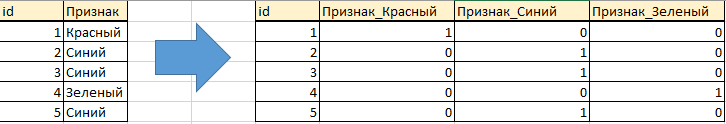

Такая обработка категориальных признаков позволяет перейти к числам, которые уже может воспринимать компьютер.

<font color=red size=7>!</font> <font color=red> Нельзя простой сопоставить каждому категориальному признаку число! Допустим, что Москва=1, Курган=2, Уфа=3. Следует ли из этого, что Москва+Курган=Уфа? Нет, конечно! Нельзя вводить отношение порядка для категориальных признаков!

Удобную реализацию такого перехода предоставляет инструмент `sklearn.preprocessing.OneHotEncoder`, которому правильно сначала показать доступный набор категориальных признаков и их значений на обучающей выборке, а затем уже можно применять (и кодировать) к тестовой выборке.

In [ ]:
# Инициализирую энкодер
oh = OneHotEncoder(sparse=False, handle_unknown='ignore')
# обучаю его (показываю какие бывают категориальные признаки и их значения на обучающей выборке)
oh.fit_transform(X_train.loc[:, cat_features].astype('string'))

oh_feature_cats_in_model = []
for i, col in enumerate(cat_features):
  oh_feature_cats_in_model += [f'{col}_{x}' for x in oh.categories_[i]]

X_train_oh = oh.transform(X_train.loc[:, cat_features].astype('string')).astype('int32')
X_train_oh = pd.DataFrame(X_train_oh, index = X_train.index, columns = oh_feature_cats_in_model)

X_test_oh = oh.transform(X_test.loc[:, cat_features].astype('string')).astype('int32')
X_test_oh = pd.DataFrame(X_test_oh, index = X_test.index, columns = oh_feature_cats_in_model)

X_train = X_train.loc[:, numeric_features].merge(X_train_oh, left_index=True, right_index=True)
X_test = X_test.loc[:, numeric_features].merge(X_test_oh, left_index=True, right_index=True)

print('Итоговый размер матрицы признаков X_train', X_train.shape)
print('Итоговый размер матрицы признаков X_test', X_test.shape)

Итоговый размер матрицы признаков X_train (1022, 295)
Итоговый размер матрицы признаков X_test (438, 295)


In [ ]:
X_train.head(3)

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,TotRmsAbvGrd,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_Unknown,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,...,PoolArea_0,PoolArea_480,PoolArea_519,PoolArea_555,PoolArea_576,PoolArea_648,PoolArea_738,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_Unknown,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_Unknown,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_Unknown,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
285,286,160,35.0,4251,2006,2007,0.0,0,0,625,625,625,625,0,1250,5,2006.0,528,0,54,0,0,0,0,6,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1359,1360,20,129.0,16737,2004,2005,66.0,1447,0,533,1980,1980,0,0,1980,8,2004.0,770,194,45,0,0,0,0,9,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
304,305,75,87.0,18386,1880,2002,0.0,0,0,1470,1470,1675,1818,0,3493,10,2003.0,870,302,0,0,0,0,0,5,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


<font color=red size=7>!</font> <font color=red>  Линейная модель является самой примитивной и не умеет сама искать сочетания признаков, умеет лишь оценивать влияние отдельного признака на значение целевой переменной, игнорируя возможные эффекты от сочетания признаков. Поможем ей, сгенерировав кросс-признаки. Игрушечный пример: пусть есть два бинарных признака "В доме есть отопление" (Да/Нет), "В доме есть электричество" (Да/Нет). Данные переменные имеют смысл, если только встречаются "вместе", т.к. дом без отопления, но с электричеством также бесполезен, как дом с электричеством, но без отопления, поэтому имеет смысл сделать переменную "В доме есть все коммуникации - и электричество и отопление", перемножив две переменные выше.

Вы можете попробовать сами создать такие атрибуты и проверить их полезность для модели. Удобно использовать `sklearn.preprocessing.PolynomialFeatures` для этого

### <font color=green> Задание линейной модели и обучение

Существует большое количество реализованных моделей линейной регрессии, например `scipy.stats.linregress` или `sklearn.linear_model.LinearRegression`, которые внутри себя уже имплементировали всё: от определения линейной модели, до процессов обучения, но мы в педагогических целях, чтобы закрепить понимание того, как модели обучаются шаг-за-шагом, напишем простую реализацию на `PyTorch` (хотя этот фреймворк обычно и не используется для подобного рода простейших моделей). Код ниже представляет собой типичную реализацию модели средствами `PyTorch`, предоставляя возможность описать компоненты модели, то, что она будет делать, как она будет учиться, какой функционал ошибки минимизировать и т.д.

Модель линейной регрессии в частном случае, когда мы пытаемся найти зависимость одной переменной от другой выглядит как $\hat{y} = b + kx$ или ещё проще: $\hat{y} = kx$.

В нашем же случае мы пытаемся предсказать цену дома, в зависимости от большого числа признаков, поэтому $x$ будет не один, а их будет много:

$$\hat{y} = b + a^{(1)}x^{(1)}+a^{(2)}x^{(2)}+...+a^{(m)}x^{(m)}$$

In [ ]:
# Описываем класс модели
class Regression(torch.nn.Module):
  def __init__(self, num_features):
    super().__init__()
    # задаем нашу самую простую модель
    self.linear=nn.Linear(num_features, 1) # nn.Linear хранит в себе функцию линейной регрессии 

  def forward(self, x):
    # когда мы будем прогонять модель, она нам будет выдавать какой-то прогноз
    y_pred = self.linear(x)
    return y_pred

# создает "пустой" (необученный) экземпляр модельки
model=Regression(X_train.shape[1])

Напомню как выглядит функция потерь для нашей задачи: $MSE = \frac{1}{n}\sum(y_i-\hat{y_i})^2$. Напомню, что она является усредненной квадратичной ошибкой прогноза нашей модели

In [ ]:
# определяем функцию ошибки
criterion = torch.nn.MSELoss()

Напомню, что после выбора функции потерь (ошибки), нужно указать правило обновления параметров функции, которые модель "выучивает", значение производной \frac{dMSE}{dk} функции ошибки MSE на объектах выборки и шагая с отрицательным знаком и скоростью $L$:

$$a_{new} = a-L\frac{dMSE}{dk}$$

In [ ]:
# создаем оптимизатор, который будет вычислять производную функции потерь и "шагать" в сторону её наименьшего значения изменяяя k
# здесь параметр `lr` отвечает за "размер шага" (упомянут как L в лекции)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)

Напомню как выглядит функция потерь для нашей задачи: $MSE = \frac{1}{n}\sum(y_i-\hat{y_i})^2$ - она является усредненной квадратичной ошибкой прогноза нашей модели

CPU times: user 2min 37s, sys: 5.52 s, total: 2min 42s
Wall time: 2min 42s


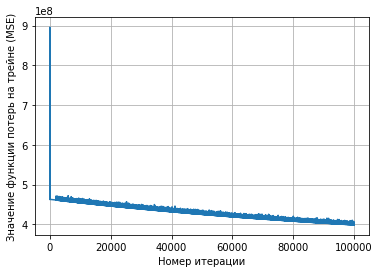

In [ ]:
%%time

NUM_OF_STEPS = 100000

loss_list = []

model.train() # перевожу можель в режим обучения

# обучаем модель
for step in range(NUM_OF_STEPS):
    X_features = torch.from_numpy(X_train.values).type(torch.float)
    y_true = torch.from_numpy(y_train.values).type(torch.float).view(X_features.size(0), -1)

    # технический шаг, требуемый исключительно фреймворком PyTorch
    optimizer.zero_grad()

    # вычисляем предсказание модели на заданных признаках
    y_pred_ = model(X_features)

    # считаем значение функции потерь
    loss = criterion(y_pred_, y_true)
    #print('Значение функции потерь на данном шаге', loss)
    loss_list.append(loss)
    # заставляем оптимизатор вычислить все градиенты (производные)
    loss.backward()

    # ...и сделать шаг в сторону параметров, дающих хорошее значение функции ошибки
    optimizer.step()

plt.plot(loss_list)
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции потерь на трейне (MSE)')
plt.grid()

In [ ]:
# беру корень из значения ошибки, чтобы "убить" квадрат ошибки, фигурирующий в функции потерь MSE
print('Значение корня из ошибки модели после обучения', np.round(loss_list[-1].item()**0.5), 'долларов')

Значение корня из ошибки модели после обучения 19968.0 долларов


In [ ]:
print('Средняя цена дома в трейн выборке', np.mean(y_train), 'долларов' )

Средняя цена дома в трейн выборке 181665.98532289627 долларов


<font color=red size=6>! </font> <font color=red> На тренировочном наборе данных большая ошибка: порядка 11% от средней цены дома. Есть куда расти!

Как можно улучшить:

* Подобрать темп обучения (+ выводить не только график ошибки на обучении, но и на некоем дополнительном валидационном датасете, который модель также не видела, и добиться ситуации, когда ошибка на валидации будет минимальна)

* Сгенерировать кросс-признаки, логарифмические, квадратичные (и другие полиномиальные признаки)

* Нормировать данные, чтобы улучшить сходимость градиентного спуска

* и т.д.

### <font color=green> Тестирование

Все оценки модели нужно проводить на тестовой выборке, которую модель не видела. Посчитаем корень из средне-квадратичной ошибки для предсказаний модели на тестовой выборке

In [ ]:
with torch.no_grad():
  model.eval() # перевожу модель в режим предсказания
  X_features_test = torch.from_numpy(X_test.values).type(torch.float)
  y_pred_test = model(X_features_test)

mse_test = round((np.sum((np.ravel(y_test.values) - np.ravel(y_pred_test.numpy()))**2) / len(y_test.values) )**0.5)

print('Корень из MSE на тестовой выборке (которую модель не видела): ', mse_test, 'квадратных долларов')

Корень из MSE на тестовой выборке (которую модель не видела):  28210 квадратных долларов


Есть куда расти! Ситуация, когда ошибка модели на тестовой выборке больше, чем на тренировочной называется переобученностью. Нужно стремиться добиться такой обобщающей способности модели, чтобы ошибки на тренировочной и тестовой выборках совпадали. На [kaggle.com](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard) на этих данных лучший результат составляет почти нулевую ошибку на тестовой выборке 